In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [3]:
# # SoftTouch Lenses complete database
# conn = psycopg2.connect(
#     host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
#     port='5432',
#     user='softtouchlenses_4e0b7c925f8444429457581f35678aea',
#     password='softtouchlenses_4e0b7c925f8444429457581f35678aea_password',
#     database='softtouchlenses_4e0b7c925f8444429457581f35678aea_db'
# )

conn = psycopg2.connect(
host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
  port = '5432'
)

In [4]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            o.total_price as order_amount,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [5]:
data = pd.read_sql(query1, conn)

In [6]:
data["order_date"] = pd.to_datetime(data["order_date"])
data[data["product_id"] == np.nan]
data = data.dropna()
data['WeekCount']=data['order_date'].dt.strftime('%Y-w%U')
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()
data = data[data['order_status'] != 'cancelled']

In [7]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [8]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [9]:
Weekly_Stats = {}
productsegstats_weekly = {}
user_cohort_labels = ['New', 'Churned (Single Use Only)', 'Recent & Loyals', 'Champions', 'Churned (Repeat Use)']
user_cohort_var_list = ['Users']#, 'Orders', 'Recency', 'AOVContribution', 'OrderValue','MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV'
product_cohort_labels=['Hero', 'High Value & Slow Moving', 'Low Value & Slow Moving', 'New Business Drivers', 'Repeat Business Drivers']
product_cohort_var_list=['ProductCount'] #'Orders','Users','AverageSellingPrice','QuantityperCart','CartPenetration','NewUserRatio','NewOrders','ASPXQpC','AOVContribution','ProductCountMix','OrdersMix','UsersMix','AOVContribution(%)','OrderPerSKU'
final_stats = pd.DataFrame()
for x in output_list:
  x3 = data[data['WeekCount'] <= x]
  try:
    userweeklydata = x3.groupby("user_id").agg(
          Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: x.nlargest(2).min()),
          First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
          OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
          #Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          #Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
          ).reset_index()
    globalmaxdateweek=x3['order_date'].max()
    userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
    userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
    userweeklydata['MaturityAge']=np.nan
    userweeklydata.loc[userweeklydata['Frequency']>1,"MaturityAge"]=(userweeklydata['Last_Date']-userweeklydata['First_Date']).dt.days.abs()
    #userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
    #userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
    userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']
    r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
    #userweeklydata['f_score'] = userweeklydata['OrdersCount'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
    userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
   # userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
    userweeklydata['m_score']=0
    userweeklydata.loc[userweeklydata['MaturityAge'].notnull(),'m_score']= userweeklydata.loc[userweeklydata['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
    #userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
    #userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']
    def CohortLables_3(df):
      if ((df['Frequency']==1) & (df['r_score']>2)):
          return "New"
      elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
          return 'Churned (Single Use Only)'
      elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
          return 'Recent & Loyals'
      elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
          return 'Champions'
      else:
          return 'Churned (Repeat Use)'
    userweeklydata['User_Cohort_Label'] = userweeklydata.apply(CohortLables_3, axis=1)
    x3=pd.merge(x3,
         userweeklydata[['user_id','User_Cohort_Label']],
         on="user_id",
         how ='left')
    totalcarts=x3['order_id'].nunique()
    product_level=x3.groupby(['product_id']).agg(
            Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
            NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
            RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
    produser=data.groupby(['product_id','user_id']).agg(
        New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    produser_newcount=produser.groupby('product_id').agg(
        New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
    ).reset_index()
    data_repeat=data[data['TrxnRank']==2]
    produser_repeatcount=data_repeat.groupby('user_id').agg(
        Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
    k.fillna(0)
    k1=k.groupby('product_id').agg(
        Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
    ).reset_index()
    productlevel=pd.merge(product_level,produser_newcount, on='product_id', how='left')
    productlevel=pd.merge(productlevel,k1,on='product_id',how='left')
    productlevel['NewRepeatConversionRatio']=productlevel['Repeat_count']/productlevel['New_count']
    productlevel=productlevel.sort_values('NewRepeatConversionRatio')
    productlevel['CartPenetration']=productlevel['Carts']/totalcarts
    productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
    productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']
    CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
    productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
    productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
    productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
    productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
    productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
    def ProductCohortLables2(df):
        if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
            return 'Hero'
        elif df['NewRepeatConversion_score'] >2:
            return 'Repeat Business Drivers'
        elif (df['CP_score'] >2):
            return 'New Business Drivers'
        elif (df['ASP_score'] >3):
            return 'High Value & Slow Moving'
        elif (df['ASP_score'] <=3):
            return 'Low Value & Slow Moving'
        else:
            return 'Low Value & Slow Moving'
    productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)
    x3=pd.merge(x3,
         productlevel[['product_id','Product Cohort Lables']],
         on="product_id",
         how ='left')
    User_Product_Level=x3.groupby(['User_Cohort_Label','Product Cohort Lables']).agg(
        Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique'),
    ).reset_index()
    Weekly_Stats[x] = User_Product_Level
    x4 = data[data['WeekCount']==x]
    x5 = pd.merge(x4,userweeklydata[['user_id','User_Cohort_Label']], on='user_id', how='left')
    x5 = pd.merge(x5,productlevel[['product_id','Product Cohort Lables']], on='product_id', how='left')
    final_stats = final_stats.append(x5, ignore_index=True)
  except:
    pass

In [10]:
final_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 0 to 2978
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               2979 non-null   int64         
 1   order_date             2979 non-null   datetime64[ns]
 2   user_id                2979 non-null   int64         
 3   product_id             2979 non-null   float64       
 4   product_name           2979 non-null   object        
 5   order_amount           2979 non-null   float64       
 6   order_status           2979 non-null   object        
 7   quantity               2979 non-null   int64         
 8   sp                     2979 non-null   float64       
 9   WeekCount              2979 non-null   object        
 10  TrxnRank               2979 non-null   float64       
 11  New                    2979 non-null   int64         
 12  Repeat                 2979 non-null   int64         
 13  ord

In [11]:
final_stats

,order_id,order_date,user_id,product_id,product_name,order_amount,order_status,quantity,sp,WeekCount,TrxnRank,New,Repeat,ordervalue,AOVContribution,DeltaDaysinOrders,DeltaOrderValues,User_Cohort_Label,Product Cohort Lables
0,3965604233390,2021-08-17,5422063714478,7.253512e+12,Affaires Color Yearly Contact Lenses Three Ton...,1000.0,Cancelled,1,1000.0,2021-w33,1.0,1,0,1000.0,0.392619,NaN,NaN,Churned (Single Use Only),Hero
1,3969073283246,2021-08-19,5425893015726,7.251689e+12,Affaires Magnetic Reading Spectacle Glasses Fo...,599.0,Delivered,1,599.0,2021-w33,1.0,1,0,599.0,0.235179,NaN,NaN,New,Low Value & Slow Moving
2,3969315209390,2021-08-19,5426204672174,7.253567e+12,SOFLENS 59 - BAUSCH & LOMB (Monthly) (6 Lenses...,899.0,Delivered,1,899.0,2021-w33,1.0,1,0,899.0,0.352964,NaN,NaN,Churned (Single Use Only),Low Value & Slow Moving
3,3969532985518,2021-08-19,5426393317550,7.253349e+12,Affaires Clear UV Contact Lenses Yearly Dispos...,600.0,Cancelled,1,600.0,2021-w33,1.0,1,0,600.0,0.235571,NaN,NaN,Churned (Single Use Only),Hero
4,3970425356462,2021-08-20,5427174932654,7.249161e+12,Power Swimming Goggles Aryca Rx Prescription O...,1399.0,Delivered,1,1399.0,2021-w33,1.0,1,0,1399.0,0.549274,NaN,NaN,New,High Value & Slow Moving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,5238081913006,2023-12-19,6566768083118,8.091588e+12,Freshlook Circle Color Allure Hazel - Daily Di...,1394.0,Delivered,1,1394.0,2023-w51,3.0,0,1,1394.0,0.547311,14.0,326.0,Champions,Repeat Business Drivers
2975,5238720823470,2023-12-20,6785939767470,7.254033e+12,Soflens Toric Bausch & Lomb (6 Lens Per Box),3998.0,Delivered,1,1999.0,2023-w51,1.0,1,0,1999.0,0.784845,NaN,NaN,New,Hero
2976,5238720823470,2023-12-20,6785939767470,7.254033e+12,Soflens Toric Bausch & Lomb (6 Lens Per Box),3998.0,Delivered,1,1999.0,2023-w51,1.0,1,0,1999.0,0.784845,0.0,0.0,New,Hero
2977,5239153098926,2023-12-20,6786525462702,7.270624e+12,Aspire Pro Monthly Disposable Contact Lens Coo...,2600.0,Delivered,1,1300.0,2023-w51,1.0,1,0,1300.0,0.510404,NaN,NaN,New,Hero


In [12]:
final_stats["User_Cohort_Label"].unique()

array(['Churned (Single Use Only)', 'New', 'Recent & Loyals', 'Champions',
       'Churned (Repeat Use)'], dtype=object)

In [13]:
#AOV Contribution
final_stats['ordervalue']=final_stats['ordervalue']
final_stats['AOVContribution']=final_stats['ordervalue']/final_stats["order_id"].nunique()
final_stats['DeltaDaysinOrders']=(final_stats.groupby('user_id').order_date.shift() - final_stats.order_date).dt.days.abs()
final_stats['DeltaOrderValues']=(final_stats.groupby('user_id').ordervalue.shift() - final_stats.ordervalue)
weekly_summary_stats = final_stats.groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
            totalorders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            totalusers=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            totalvalue=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            SKUCounts=pd.NamedAgg(column='product_id', aggfunc='nunique')
      ).reset_index()
newdf=final_stats[final_stats['New']==1].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    newusercount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
     ).reset_index()
cancelled_orders = final_stats[final_stats['order_status'] == 'Cancelled'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()

delivered_orders = final_stats[final_stats['order_status'] == 'Delivered'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()
weekly_summary_stats = weekly_summary_stats.merge(newdf, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats =weekly_summary_stats.merge(cancelled_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats = weekly_summary_stats.merge(delivered_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats['repeatusercount']=weekly_summary_stats['totalusers']-weekly_summary_stats['newusercount']
weekly_summary_stats['AOV'] = weekly_summary_stats['totalvalue']/ weekly_summary_stats['totalorders']


In [14]:
final_stats["Retention"] = 0
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 0) & (final_stats["DeltaDaysinOrders"] <= 90) , "Retention"] = "Retained"
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 90), "Retention"] = "Not-Retained"
retained_df = final_stats[final_stats['Retention'] == 'Retained'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).size().reset_index(name='Retained_Users')
weekly_summary_stats = pd.merge(weekly_summary_stats, retained_df, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WeekCount              682 non-null    object 
 1   User_Cohort_Label      682 non-null    object 
 2   Product Cohort Lables  682 non-null    object 
 3   totalorders            682 non-null    int64  
 4   totalusers             682 non-null    int64  
 5   totalvalue             682 non-null    float64
 6   quantity               682 non-null    int64  
 7   SKUCounts              682 non-null    int64  
 8   newusercount           451 non-null    float64
 9   CancellationCount      154 non-null    float64
 10  DeliveryCount          649 non-null    float64
 11  repeatusercount        451 non-null    float64
 12  AOV                    682 non-null    float64
 13  Retained_Users         155 non-null    float64
dtypes: float64(7), int64(4), object(3)
memory usage: 79.9+ KB


In [15]:
key_metrices = ['WeekCount','User_Cohort_Label','Product Cohort Lables','totalorders', 'totalvalue', 'repeatusercount','newusercount', 'AOV']
weekly_summary_stats = weekly_summary_stats[key_metrices]

weekly_summary_stats = weekly_summary_stats.rename(columns={
    'totalorders':'Total_Orders',
    'totalvalue': 'Total_Value',
    'repeatusercount': 'No_of_Repeat_Users',
    'newusercount': 'No_of_New_Users(First_Time_Users)',
    'AOV': 'Average_Order_Value'
})
weekly_summary_stats=weekly_summary_stats.fillna(0)

In [16]:
weekly_summary_stats["User_Cohort_Label"].unique()

array(['Churned (Single Use Only)', 'New', 'Champions', 'Recent & Loyals',
       'Churned (Repeat Use)'], dtype=object)

In [17]:
weekly_summary_stats

,WeekCount,User_Cohort_Label,Product Cohort Lables,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),Average_Order_Value
0,2021-w33,Churned (Single Use Only),Hero,2,1600.0,0.0,2.0,800.00
1,2021-w33,Churned (Single Use Only),Low Value & Slow Moving,1,899.0,0.0,1.0,899.00
2,2021-w33,New,Hero,1,1500.0,0.0,1.0,1500.00
3,2021-w33,New,High Value & Slow Moving,1,1399.0,0.0,1.0,1399.00
4,2021-w33,New,Low Value & Slow Moving,1,599.0,0.0,1.0,599.00
...,...,...,...,...,...,...,...,...
677,2023-w51,Champions,New Business Drivers,1,3488.0,0.0,0.0,3488.00
678,2023-w51,Champions,Repeat Business Drivers,1,1394.0,0.0,0.0,1394.00
679,2023-w51,New,Hero,4,12745.0,0.0,4.0,3186.25
680,2023-w51,New,Low Value & Slow Moving,1,799.0,0.0,1.0,799.00


In [18]:
weekly_summary_stats['AOV_Contribution'] = weekly_summary_stats['Total_Value'] / weekly_summary_stats.groupby('WeekCount')['Total_Orders'].transform('sum')

In [19]:
weekly_summary_stats = weekly_summary_stats.drop("Average_Order_Value", axis=1)

In [20]:
weekly_summary_stats["key"] = weekly_summary_stats["User_Cohort_Label"] + "-" + weekly_summary_stats["Product Cohort Lables"]

In [21]:
weekly_summary_stats.drop(['User_Cohort_Label', 'Product Cohort Lables'], axis=1, inplace=True)

In [22]:
weekly_summary_stats.set_index("WeekCount", inplace=True)

In [23]:
weekly_summary_stats

,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),AOV_Contribution,key
WeekCount,,,,,,
2021-w33,2,1600.0,0.0,2.0,266.666667,Churned (Single Use Only)-Hero
2021-w33,1,899.0,0.0,1.0,149.833333,Churned (Single Use Only)-Low Value & Slow Moving
2021-w33,1,1500.0,0.0,1.0,250.000000,New-Hero
2021-w33,1,1399.0,0.0,1.0,233.166667,New-High Value & Slow Moving
2021-w33,1,599.0,0.0,1.0,99.833333,New-Low Value & Slow Moving
...,...,...,...,...,...,...
2023-w51,1,3488.0,0.0,0.0,249.142857,Champions-New Business Drivers
2023-w51,1,1394.0,0.0,0.0,99.571429,Champions-Repeat Business Drivers
2023-w51,4,12745.0,0.0,4.0,910.357143,New-Hero


In [24]:
grouped_dict = {week: group for week, group in weekly_summary_stats.groupby(level='WeekCount')}
for week, df in grouped_dict.items():
    df = df.reset_index(drop=True)
    df.set_index('key', inplace=True)
    grouped_dict[week] = df

In [25]:
all_combinations = list(itertools.product(user_cohort_labels, product_cohort_labels))
formatted_combinations = [f'{user}-{product}' for user, product in all_combinations]

In [26]:
formatted_combinations

['New-Hero',
 'New-High Value & Slow Moving',
 'New-Low Value & Slow Moving',
 'New-New Business Drivers',
 'New-Repeat Business Drivers',
 'Churned (Single Use Only)-Hero',
 'Churned (Single Use Only)-High Value & Slow Moving',
 'Churned (Single Use Only)-Low Value & Slow Moving',
 'Churned (Single Use Only)-New Business Drivers',
 'Churned (Single Use Only)-Repeat Business Drivers',
 'Recent & Loyals-Hero',
 'Recent & Loyals-High Value & Slow Moving',
 'Recent & Loyals-Low Value & Slow Moving',
 'Recent & Loyals-New Business Drivers',
 'Recent & Loyals-Repeat Business Drivers',
 'Champions-Hero',
 'Champions-High Value & Slow Moving',
 'Champions-Low Value & Slow Moving',
 'Champions-New Business Drivers',
 'Champions-Repeat Business Drivers',
 'Churned (Repeat Use)-Hero',
 'Churned (Repeat Use)-High Value & Slow Moving',
 'Churned (Repeat Use)-Low Value & Slow Moving',
 'Churned (Repeat Use)-New Business Drivers',
 'Churned (Repeat Use)-Repeat Business Drivers']

In [27]:
for key, df in grouped_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [28]:
averages_dict = {}
weeks = list(grouped_dict.keys())

for i in range(8, len(weeks)):
    week = weeks[i]
    df = grouped_dict[week]
    avg_df = df.rolling(window=8, min_periods=1).mean().shift(1)
    avg_df = avg_df.iloc[1:]
    averages_dict[week] = avg_df

In [29]:
for key, df in averages_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [30]:
result_list = []

for key, dataframe in grouped_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)

result_df_1= pd.concat(result_list, ignore_index=True)

In [31]:
result_df_melted_1 = pd.melt(result_df_1, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_1.rename(columns={'key': 'WeekCount'}, inplace=True)

In [32]:
result_list = []

for key, dataframe in averages_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T  # Convert sum_result to a DataFrame and transpose
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]  # Use the first index value
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)
result_df_2= pd.concat(result_list, ignore_index=True)

In [33]:
result_df_melted_2 = pd.melt(result_df_2, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_2.rename(columns={'key': 'WeekCount'}, inplace=True)

In [34]:
def create_metric_df(data_dict, metric_column):
    curr_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # curr_week_df = curr_week_df.append(temp_df, ignore_index=True)
        curr_week_df = pd.concat([curr_week_df, temp_df], ignore_index=True)

    curr_week_df = curr_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })

    return curr_week_df
curr_week_df = create_metric_df(grouped_dict, 'Total_Value')

In [35]:
def create_average_df(data_dict, metric_column):

    avg_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # avg_week_df = avg_week_df.append(temp_df, ignore_index=True)
        avg_week_df = pd.concat([avg_week_df, temp_df], ignore_index=True)

    avg_week_df = avg_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })
    return avg_week_df

avg_week_df = create_average_df(averages_dict, 'Total_Value')


In [36]:
current_week_dataframe = pd.concat([result_df_melted_1, curr_week_df], axis=0)
current_week_dataframe = current_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [37]:
current_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Current Week Value'}, inplace=True)

In [38]:
keys_list = list(averages_dict.keys())

In [39]:
current_week_dataframe = current_week_dataframe[current_week_dataframe['WeekCount'].isin(keys_list)]

In [40]:
last_8_week_dataframe = pd.concat([result_df_melted_2, avg_week_df], axis=0)
last_8_week_dataframe = last_8_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [41]:
last_8_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Last 8 Week Value'}, inplace=True)

In [42]:
merged_dataframe = pd.merge(current_week_dataframe, last_8_week_dataframe, on=['WeekCount', 'Variables'], how='left')
merged_dataframe = merged_dataframe.fillna(0)

In [43]:
primary_explanatory_vars = ['Total_Orders', 'No_of_Repeat_Users', 'AOV_Contribution', 'No_of_New_Users(First_Time_Users)', '90_Day_Retention']
target_vars = ["Total_Value"]

In [44]:
merged_dataframe.loc[merged_dataframe['Variables'].isin(target_vars), 'Tag'] = 'Target_Variable'
merged_dataframe.loc[merged_dataframe['Variables'].isin(primary_explanatory_vars), 'Tag'] = 'Primary_Explanatory'
merged_dataframe.loc[merged_dataframe['Variables'].isin(formatted_combinations), 'Tag'] = 'Secondary_Explanatory'

In [45]:
merged_dataframe.to_csv("Toffee_final_summmary.csv")

In [46]:
new_df_1 = merged_dataframe[merged_dataframe["Tag"] == "Secondary_Explanatory"]

In [47]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag
0,2021-w41,Churned (Single Use Only)-Repeat Business Drivers,0.0,867.25,Secondary_Explanatory
1,2021-w41,Recent & Loyals-Hero,0.0,172.50,Secondary_Explanatory
2,2021-w41,Recent & Loyals-High Value & Slow Moving,0.0,0.00,Secondary_Explanatory
3,2021-w41,Recent & Loyals-Low Value & Slow Moving,0.0,0.00,Secondary_Explanatory
4,2021-w41,Recent & Loyals-New Business Drivers,0.0,0.00,Secondary_Explanatory
...,...,...,...,...,...
3440,2023-w51,Champions-New Business Drivers,3488.0,5779.00,Secondary_Explanatory
3441,2023-w51,Champions-Hero,5779.0,0.00,Secondary_Explanatory
3446,2023-w51,Churned (Repeat Use)-New Business Drivers,0.0,0.00,Secondary_Explanatory
3448,2023-w51,Churned (Single Use Only)-Hero,0.0,3655.75,Secondary_Explanatory


In [48]:
new_df_1[['User_Cohort_Lables', 'Product_Cohort_Lables']] = new_df_1['Variables'].str.split('-', expand=True)

In [49]:
new_df_1["User_Cohort_Lables"].unique()

array(['Churned (Single Use Only)', 'Recent & Loyals', 'Champions',
       'Churned (Repeat Use)', 'New'], dtype=object)

In [50]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Lables,Product_Cohort_Lables
0,2021-w41,Churned (Single Use Only)-Repeat Business Drivers,0.0,867.25,Secondary_Explanatory,Churned (Single Use Only),Repeat Business Drivers
1,2021-w41,Recent & Loyals-Hero,0.0,172.50,Secondary_Explanatory,Recent & Loyals,Hero
2,2021-w41,Recent & Loyals-High Value & Slow Moving,0.0,0.00,Secondary_Explanatory,Recent & Loyals,High Value & Slow Moving
3,2021-w41,Recent & Loyals-Low Value & Slow Moving,0.0,0.00,Secondary_Explanatory,Recent & Loyals,Low Value & Slow Moving
4,2021-w41,Recent & Loyals-New Business Drivers,0.0,0.00,Secondary_Explanatory,Recent & Loyals,New Business Drivers
...,...,...,...,...,...,...,...
3440,2023-w51,Champions-New Business Drivers,3488.0,5779.00,Secondary_Explanatory,Champions,New Business Drivers
3441,2023-w51,Champions-Hero,5779.0,0.00,Secondary_Explanatory,Champions,Hero
3446,2023-w51,Churned (Repeat Use)-New Business Drivers,0.0,0.00,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers
3448,2023-w51,Churned (Single Use Only)-Hero,0.0,3655.75,Secondary_Explanatory,Churned (Single Use Only),Hero


In [51]:
df_1 = new_df_1[new_df_1["WeekCount"] == "2023-w48"]

In [52]:
df_1["Current Week Value"].sum()

76727.0

In [53]:
merged_dataframe[merged_dataframe["WeekCount"] == "2023-w48"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag
3330,2023-w48,New-Repeat Business Drivers,0.000000,12787.833333,Secondary_Explanatory
3331,2023-w48,New-High Value & Slow Moving,0.000000,15345.400000,Secondary_Explanatory
3332,2023-w48,Churned (Repeat Use)-New Business Drivers,0.000000,0.000000,Secondary_Explanatory
3333,2023-w48,Churned (Single Use Only)-Hero,0.000000,10961.000000,Secondary_Explanatory
3334,2023-w48,Churned (Single Use Only)-High Value & Slow Mo...,0.000000,9590.875000,Secondary_Explanatory
3335,2023-w48,Churned (Single Use Only)-Low Value & Slow Moving,0.000000,4908.375000,Secondary_Explanatory
3336,2023-w48,Churned (Single Use Only)-New Business Drivers,0.000000,4808.500000,Secondary_Explanatory
3337,2023-w48,Churned (Single Use Only)-Repeat Business Drivers,0.000000,1505.500000,Secondary_Explanatory
3338,2023-w48,Recent & Loyals-Hero,0.000000,1280.875000,Secondary_Explanatory
3339,2023-w48,Recent & Loyals-High Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory


In [54]:
merged_dataframe["Difference"] = merged_dataframe['Current Week Value'] - merged_dataframe['Last 8 Week Value']

In [55]:
top_4_bot_4_df = merged_dataframe.groupby('WeekCount').apply(lambda group: pd.concat([group[group['Tag'] == 'Secondary_Explanatory'].nlargest(4, 'Difference'), group[group['Tag'] == 'Secondary_Explanatory'].nsmallest(4, 'Difference')])).reset_index(drop=True)

In [56]:
top_4_bot_4_df

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
0,2021-w41,New-Hero,6200.0,1885.000000,Secondary_Explanatory,4315.000000
1,2021-w41,Churned (Repeat Use)-Hero,1885.0,0.000000,Secondary_Explanatory,1885.000000
2,2021-w41,New-New Business Drivers,5558.0,4042.500000,Secondary_Explanatory,1515.500000
3,2021-w41,Recent & Loyals-High Value & Slow Moving,0.0,0.000000,Secondary_Explanatory,0.000000
4,2021-w41,New-High Value & Slow Moving,0.0,3755.750000,Secondary_Explanatory,-3755.750000
...,...,...,...,...,...,...
915,2023-w51,Recent & Loyals-High Value & Slow Moving,0.0,0.000000,Secondary_Explanatory,0.000000
916,2023-w51,New-Low Value & Slow Moving,799.0,5851.500000,Secondary_Explanatory,-5052.500000
917,2023-w51,New-High Value & Slow Moving,0.0,4874.333333,Secondary_Explanatory,-4874.333333
918,2023-w51,New-Repeat Business Drivers,0.0,4178.000000,Secondary_Explanatory,-4178.000000


In [57]:
merged_dataframe[merged_dataframe["WeekCount"] == "2023-w50"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
3390,2023-w50,Churned (Single Use Only)-Low Value & Slow Moving,0.000000,7718.750000,Secondary_Explanatory,-7718.750000
3391,2023-w50,Churned (Single Use Only)-New Business Drivers,0.000000,3597.750000,Secondary_Explanatory,-3597.750000
3392,2023-w50,Churned (Single Use Only)-Repeat Business Drivers,0.000000,1322.500000,Secondary_Explanatory,-1322.500000
3393,2023-w50,Recent & Loyals-High Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory,0.000000
3394,2023-w50,Recent & Loyals-Low Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory,0.000000
3395,2023-w50,Recent & Loyals-Repeat Business Drivers,0.000000,0.000000,Secondary_Explanatory,0.000000
3396,2023-w50,Champions-Repeat Business Drivers,0.000000,0.000000,Secondary_Explanatory,0.000000
3397,2023-w50,Champions-Low Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory,0.000000
3398,2023-w50,Churned (Repeat Use)-Hero,0.000000,0.000000,Secondary_Explanatory,0.000000
3399,2023-w50,Churned (Repeat Use)-High Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory,0.000000


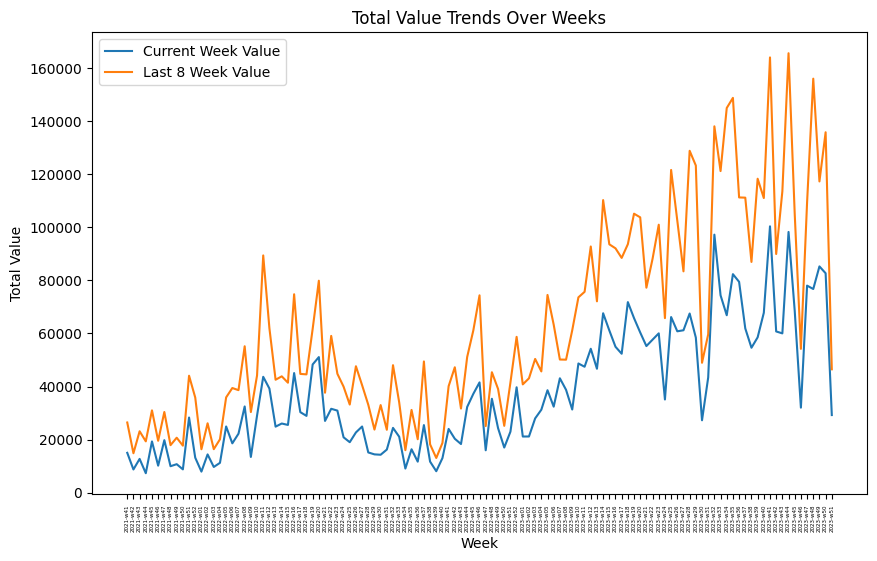

In [58]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Total_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Total Value')
plt.title('Total Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

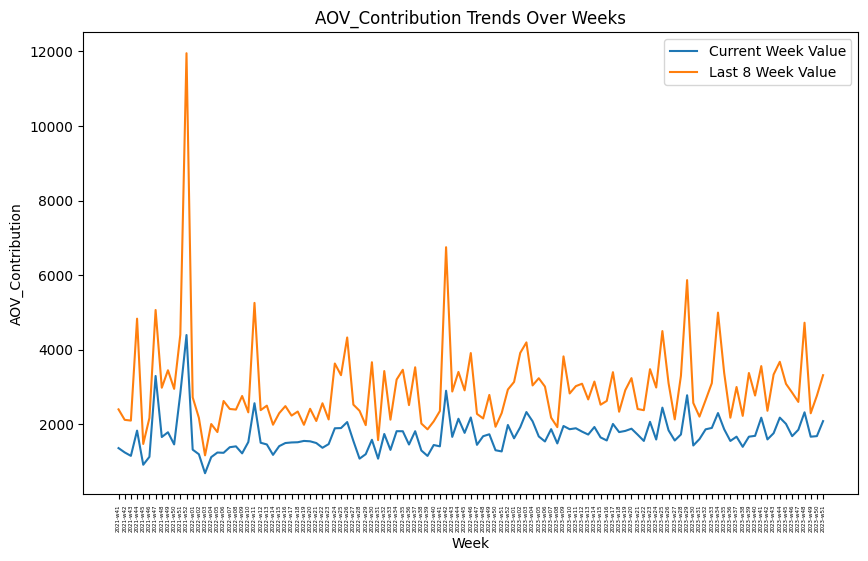

In [66]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'AOV_Contribution']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('AOV_Contribution')
plt.title('AOV_Contribution Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

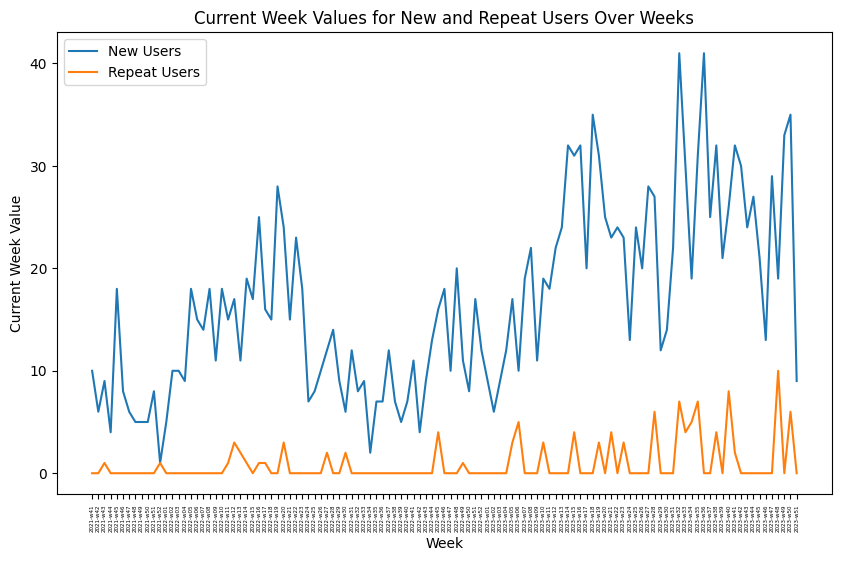

In [60]:
import matplotlib.pyplot as plt

# Filter for 'No_of_New_Users(First_Time_Users)'
new_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_New_Users(First_Time_Users)']

# Filter for 'No_of_Repeat_Users'
repeat_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value' for New Users
plt.plot(new_users_rows['WeekCount'], new_users_rows['Current Week Value'], label='New Users')

# Plot 'WeekCount' versus 'Current Week Value' for Repeat Users
plt.plot(repeat_users_rows['WeekCount'], repeat_users_rows['Current Week Value'], label='Repeat Users')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Current Week Value')
plt.title('Current Week Values for New and Repeat Users Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()


In [61]:
# total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']
# # Plot the graph
# plt.figure(figsize=(10, 6))

# # Plot 'WeekCount' versus 'Current Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# # Plot 'WeekCount' versus 'Last 8 Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# # Set labels and title
# plt.xlabel('Week')
# plt.ylabel('No_of_Repeat_Users')
# plt.title('No_of_Repeat_Users Trends Over Weeks')
# plt.xticks(rotation=90, fontsize=4)
# plt.legend()

# # Show the plot
# plt.show()

In [62]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Lables,Product_Cohort_Lables
0,2021-w41,Churned (Single Use Only)-Repeat Business Drivers,0.0,867.25,Secondary_Explanatory,Churned (Single Use Only),Repeat Business Drivers
1,2021-w41,Recent & Loyals-Hero,0.0,172.50,Secondary_Explanatory,Recent & Loyals,Hero
2,2021-w41,Recent & Loyals-High Value & Slow Moving,0.0,0.00,Secondary_Explanatory,Recent & Loyals,High Value & Slow Moving
3,2021-w41,Recent & Loyals-Low Value & Slow Moving,0.0,0.00,Secondary_Explanatory,Recent & Loyals,Low Value & Slow Moving
4,2021-w41,Recent & Loyals-New Business Drivers,0.0,0.00,Secondary_Explanatory,Recent & Loyals,New Business Drivers
...,...,...,...,...,...,...,...
3440,2023-w51,Champions-New Business Drivers,3488.0,5779.00,Secondary_Explanatory,Champions,New Business Drivers
3441,2023-w51,Champions-Hero,5779.0,0.00,Secondary_Explanatory,Champions,Hero
3446,2023-w51,Churned (Repeat Use)-New Business Drivers,0.0,0.00,Secondary_Explanatory,Churned (Repeat Use),New Business Drivers
3448,2023-w51,Churned (Single Use Only)-Hero,0.0,3655.75,Secondary_Explanatory,Churned (Single Use Only),Hero


In [63]:
# # Group the data by Product Cohort Labels
# grouped_data = new_df_1.groupby('Product_Cohort_Lables')

# # Plot the data for each Product Cohort Label
# plt.figure(figsize=(12, 8))

# for label, group in grouped_data:
#     plt.plot(group['WeekCount'], group['Current Week Value'], label=label)

# plt.xlabel('Week Count')
# plt.ylabel('Current Week Value')
# plt.title('Current Week Value for Each Product Cohort Label')
# plt.legend(title='Product Cohort Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

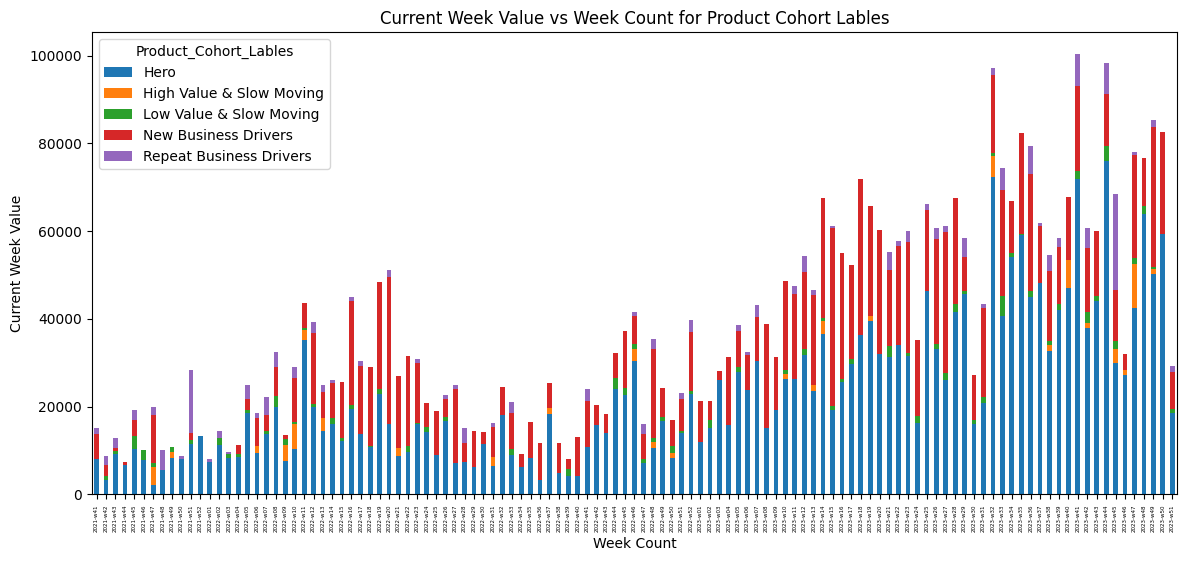

In [64]:
df_agg = new_df_1.groupby(['WeekCount', 'Product_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df = df_agg.pivot(index='WeekCount', columns='Product_Cohort_Lables', values='Current Week Value')
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for Product Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax.tick_params(axis='x', labelsize=4)
plt.show()

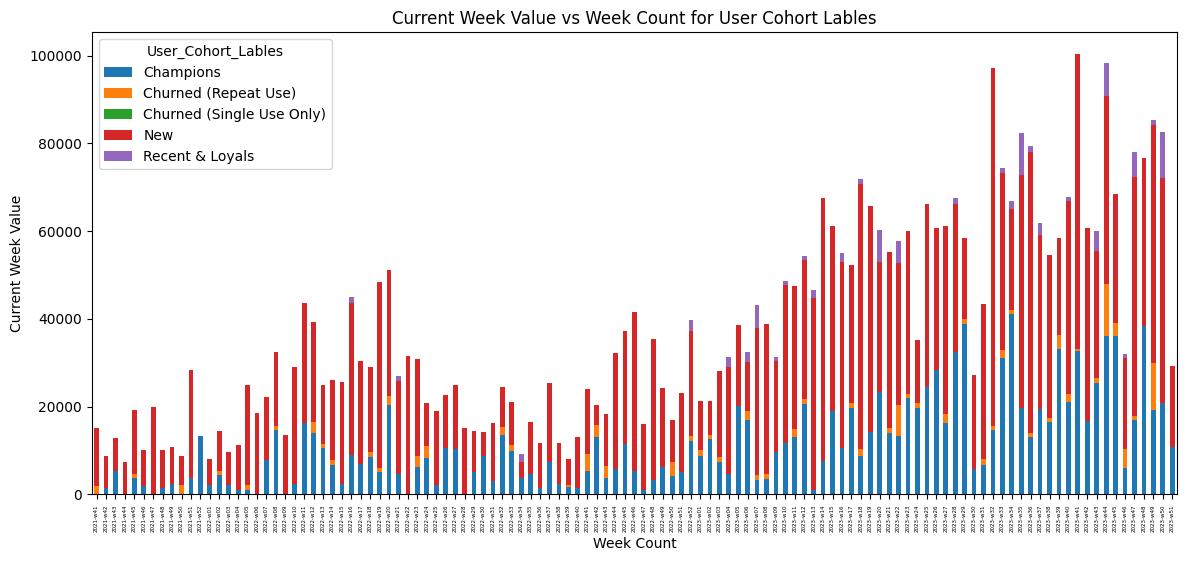

In [65]:
df_agg_user = new_df_1.groupby(['WeekCount', 'User_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df_user = df_agg_user.pivot(index='WeekCount', columns='User_Cohort_Lables', values='Current Week Value')
ax_user = pivot_df_user.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for User Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax_user.tick_params(axis='x', labelsize=4)
plt.show()